In [1]:
import pickle
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.core.display import HTML, display

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

from theano import shared
import theano.tensor as tt
import pymc3 as pm
from tqdm import tqdm

import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter
from seaborn import PairGrid, heatmap, kdeplot
import cmocean.cm as cmo
from pymc_utils import PyMCModel
from pymc_utils import subset_significant_feature
from pymc_utils import lasso_regression, hs_regression
from pymc_utils import plot_fits_w_estimates
from pymc_utils import plot_fits_with_unc

In [2]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
display(HTML("<style>.container{width: 90% !important}</style>"))

In [3]:
df_aphy = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')
#df_aphy_wi = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_PolyFeatures_SWF.pkl')

In [4]:
df_aphy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 28 columns):
sin_doy_s         162 non-null float64
cos_doy_s         162 non-null float64
sin_minofday_s    162 non-null float64
cos_minofday_s    162 non-null float64
x_s               162 non-null float64
y_s               162 non-null float64
z_s               162 non-null float64
log10_etopo2_s    162 non-null float64
oisst_s           162 non-null float64
solz_s            162 non-null float64
PC1_s             162 non-null float64
PC2_s             162 non-null float64
PC3_s             162 non-null float64
PC4_s             162 non-null float64
PC5_s             162 non-null float64
PC6_s             162 non-null float64
aphy411           162 non-null float64
aphy443           162 non-null float64
aphy489           162 non-null float64
aphy510           162 non-null float64
aphy555           162 non-null float64
aphy670           162 non-null float64
log10_aphy411     162 non-null float6

In [5]:
aphys = df_aphy.filter(regex='^aphy').columns
df_aphy.drop(aphys, axis=1, inplace=True)

In [6]:
def PlotHeatMap(df, ax=None,):
    if ax is None:
        _, ax = pl.subplots(figsize=(20, 20))
    dfc = df.corr().iloc[1:, :-1]
    heatmap(dfc, vmin=-1, vmax=1, cmap=cmo.balance_r, annot=True, annot_kws={'fontsize': 13},
            ax=ax, mask=np.triu(np.ones([dfc.shape[1]]*2), k=1), fmt='.1f')
    ax.set_facecolor('k')
    return ax


def plot_obs_against_ppc(y_obs, ppc, ax=None, plot_1_to_1=False, **scatter_kwds):
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 10))
    ppc_mean = ppc.mean(axis=0)
    ax.scatter(y_obs, ppc_mean, edgecolor='k', **scatter_kwds)
    if plot_1_to_1:
        min_ = min(ppc_mean.min(), y_obs.min())
        max_ = max(ppc_mean.max(), y_obs.max())
        ax.plot([min_, max_], [min_, max_], ls='--', color='k', label='1:1')


def evaluate_model(model,  y_train_, y_test_, ax1_title=None, ax2_title=None, ax3_title=None,):
    f = pl.figure(figsize=(15, 15))
    ax1 = pl.subplot2grid((2, 2), (0, 0))
    ax2 = pl.subplot2grid((2, 2), (0, 1))
    ax3 = pl.subplot2grid((2, 2), (1, 0), colspan=2)
    X_shared.set_value(X_s_train.values)
    ppc_train_ = model.predict(likelihood_name='likelihood' )
    model.plot_model_fits(y_train_, ppc_train_, loss_metric='mae',
                          ax=ax1, title=ax1_title, );
    X_shared.set_value(X_s_test.values)
    ppc_test_ = model.predict(likelihood_name='likelihood')
    model.plot_model_fits(y_test_, ppc_test_, loss_metric='mae',
                          ax=ax2, title=ax2_title, );
    plot_fits_w_estimates(y_test_, ppc_test_, ax=ax3)
    ax3.set_title(ax3_title)
    return f, ppc_train_, ppc_test_

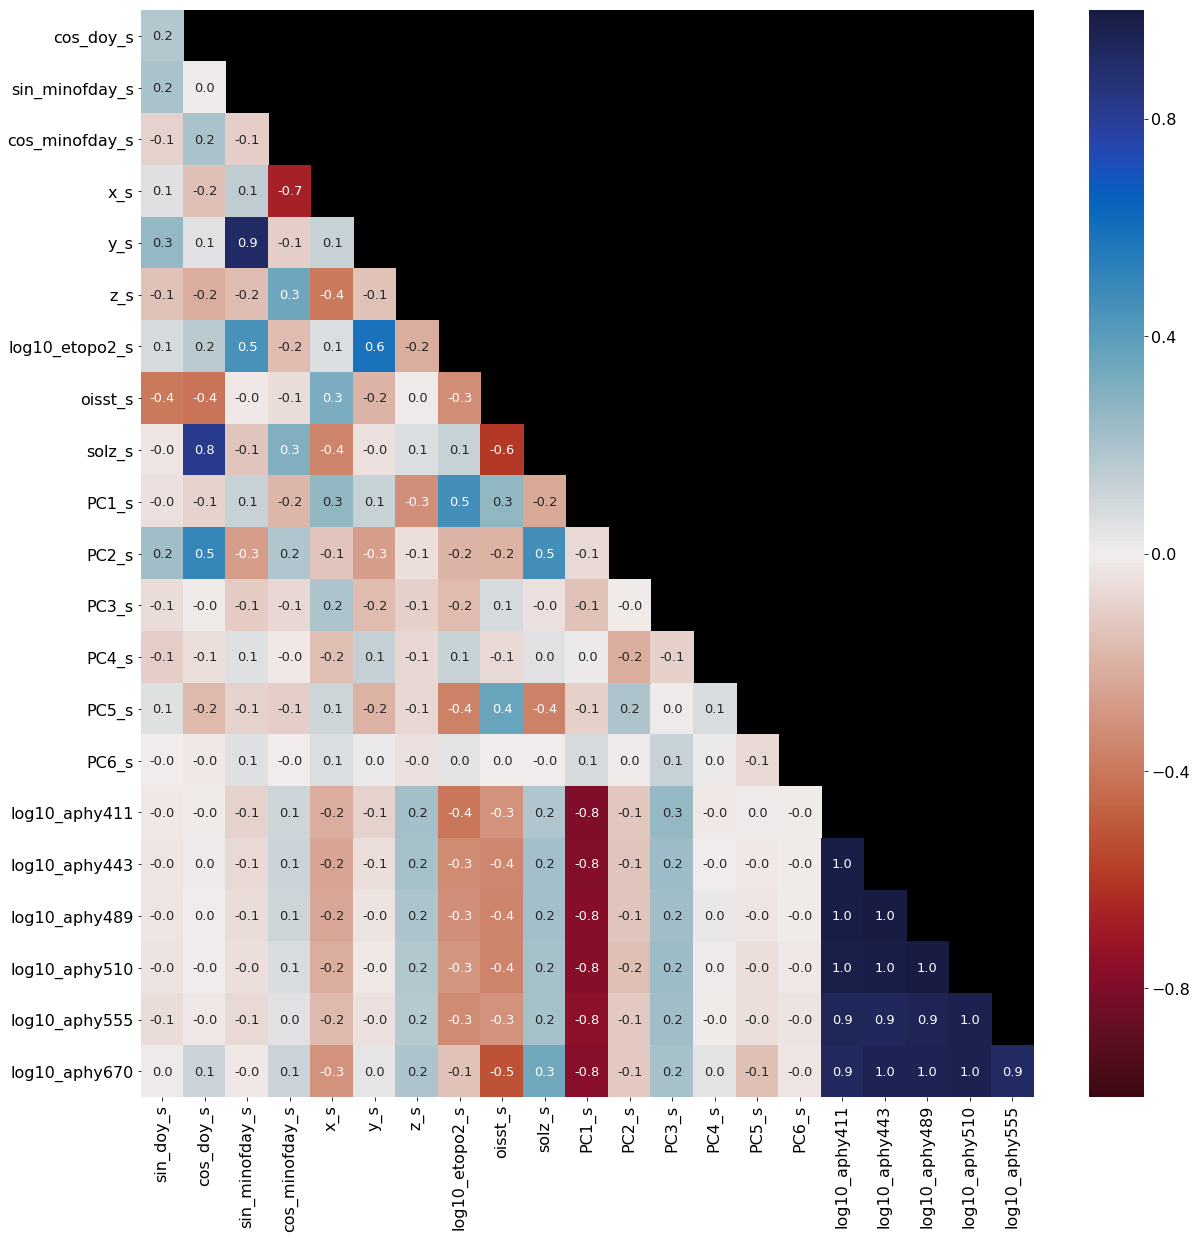

In [7]:
f, ax = pl.subplots(figsize=(20, 20))
ax = PlotHeatMap(df_aphy, ax=ax)
f.savefig('./figJar/aphy_heatmap.png', dpi=150, format='png')

### <u>Modeling</u>

Below the smaller dataset (no interactions features one entry where all PC's are NaNs.
I just drop that row for now. To impute the missing predictors is a bit more complicated than when predicted values are missing.

In [8]:
feat_beg = 'sin_doy_s'
feat_end_ni = 'PC6_s'
X_s = df_aphy.loc[:, :feat_end_ni]
y = df_aphy.loc[:, 'log10_aphy411':]

In [9]:
feature_labels=df_aphy.loc[:,:feat_end_ni].columns.tolist()

In [10]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y, test_size=0.1,
                                                       random_state=42)

### A$\phi$ 411

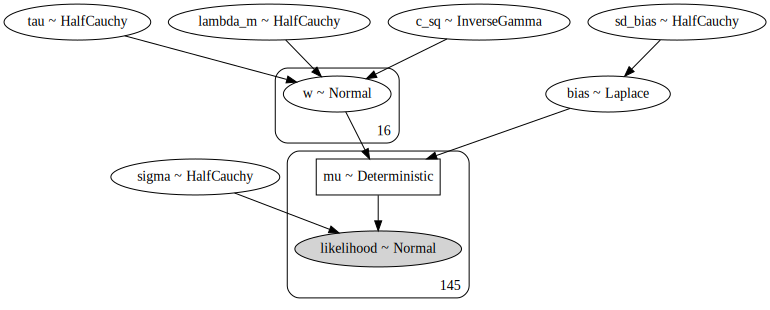

In [11]:
X_shared = shared(X_s_train.values)
m_hshoe_411 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy411, model_name='hshoe_aphy411',
                        ylabel='likelihood', regularized=True)
m_hshoe_411.show_model()

In [12]:
m_hshoe_411.fit(tune=7000, nuts_kwargs=dict(target_accept=0.82))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 36000/36000 [00:43<00:00, 828.02draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.


In [17]:
X_shared.set_value(X_s_test.values)
ppc_test_411 = pm.sample_ppc(m_hshoe_411.trace_, model=m_hshoe_411.model)['likelihood']

100%|██████████| 2000/2000 [00:01<00:00, 1321.86it/s]


In [18]:
ppc_test_411.shape

(2000, 17)

### A$\phi$ 443

In [19]:
X_shared = shared(X_s_train.values)
m_hshoe_443 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy443, model_name='hshoe_aphy443',
                        ylabel='likelihood', regularized=True)
m_hshoe_443.fit(tune=7000, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 36000/36000 [00:44<00:00, 816.25draws/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 185 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6184047223523456, but should be close to 0.85. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7697158310336856, but should be close to 0.85. Try to increase the number of tuning steps.


In [21]:
X_shared.set_value(X_s_test.values)
ppc_test_443 = pm.sample_ppc(m_hshoe_443.trace_, model=m_hshoe_443.model)['likelihood']

100%|██████████| 2000/2000 [00:01<00:00, 1266.55it/s]


### A$\phi$ 489

In [22]:
X_shared = shared(X_s_train.values)
m_hshoe_489 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy489, model_name='hshoe_aphy489',
                        ylabel='likelihood', regularized=True)
m_hshoe_489.fit(tune=7000, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 36000/36000 [00:44<00:00, 812.05draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [23]:
X_shared.set_value(X_s_test.values)
ppc_test_489 = pm.sample_ppc(m_hshoe_489.trace_, model=m_hshoe_489.model)['likelihood']

100%|██████████| 2000/2000 [00:01<00:00, 1284.72it/s]


In [24]:
X_shared = shared(X_s_train.values)
m_hshoe_510 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy510, model_name='hshoe_aphy510',
                        ylabel='likelihood', regularized=True)
m_hshoe_510.fit(tune=7000, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 36000/36000 [00:45<00:00, 783.21draws/s]
There were 401 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3787224257225602, but should be close to 0.85. Try to increase the number of tuning steps.
There were 238 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.595099154201417, but should be close to 0.85. Try to increase the number of tuning steps.


In [25]:
X_shared.set_value(X_s_test.values)
ppc_test_510 = pm.sample_ppc(m_hshoe_510.trace_, model=m_hshoe_510.model)['likelihood']

100%|██████████| 2000/2000 [00:01<00:00, 1265.46it/s]


In [26]:
X_shared = shared(X_s_train.values)
m_hshoe_555 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy555, model_name='hshoe_aphy555',
                        ylabel='likelihood', regularized=True)
m_hshoe_555.fit(tune=7000, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 36000/36000 [00:44<00:00, 803.51draws/s]
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.59413075467573, but should be close to 0.85. Try to increase the number of tuning steps.


In [27]:
X_shared.set_value(X_s_test.values)
ppc_test_555 = pm.sample_ppc(m_hshoe_555.trace_, model=m_hshoe_555.model)['likelihood']

100%|██████████| 2000/2000 [00:01<00:00, 1293.31it/s]


In [28]:
X_shared = shared(X_s_train.values)
m_hshoe_670 = PyMCModel(hs_regression, X_shared, y_train.log10_aphy670, model_name='hshoe_aphy670',
                        ylabel='likelihood', regularized=True)
m_hshoe_670.fit(tune=7000, nuts_kwargs=dict(target_accept=0.85))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bias, w, c_sq, lambda_m, sd_bias, tau]
Sampling 4 chains: 100%|██████████| 36000/36000 [00:44<00:00, 808.30draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.766990485672024, but should be close to 0.85. Try to increase the number of tuning steps.


In [29]:
X_shared.set_value(X_s_test.values)
ppc_test_670 = pm.sample_ppc(m_hshoe_670.trace_, model=m_hshoe_670.model)['likelihood']

100%|██████████| 2000/2000 [00:01<00:00, 1294.29it/s]


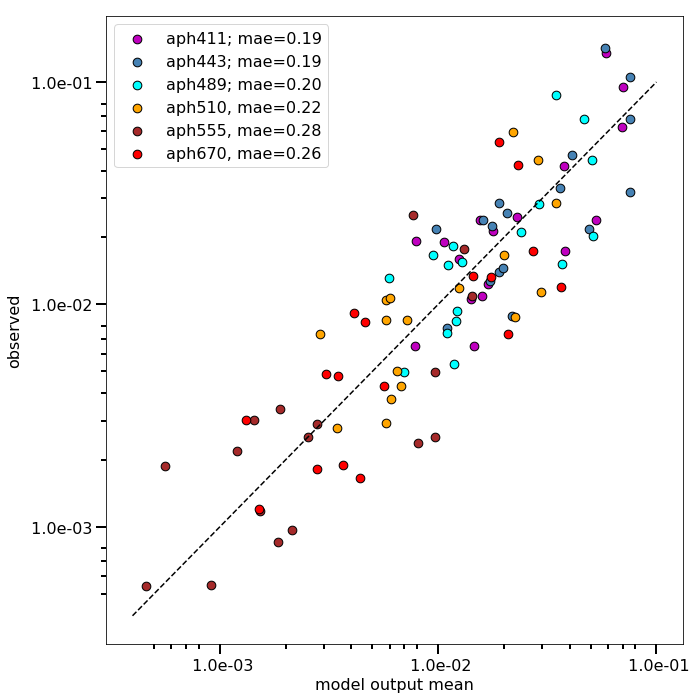

In [38]:
minor_ticks = np.concatenate((np.arange(5e-4, 9e-4, 1e-4), np.arange(2e-3, 9e-3, 1e-3), np.arange(2e-2, 9e-2, 1e-2)))
f, ax_ = pl.subplots(figsize=(10, 10))
plot_obs_against_ppc(y_test.log10_aphy411, ppc_test_411, color='m', label='aph411; mae=0.19', s=75, ax=ax_) 
plot_obs_against_ppc(y_test.log10_aphy443, ppc_test_443, color='steelblue', ax=ax_, label='aph443; mae=0.19', s=75,)
plot_obs_against_ppc(y_test.log10_aphy489, ppc_test_489, color='cyan', ax=ax_, label='aph489; mae=0.20', s=75, )
plot_obs_against_ppc(y_test.log10_aphy510, ppc_test_510, color='orange', ax=ax_, label='aph510, mae=0.22', s=75,)
plot_obs_against_ppc(y_test.log10_aphy555, ppc_test_555, color='brown', ax=ax_, label='aph555, mae=0.28', s=75, )
plot_obs_against_ppc(y_test.log10_aphy670, ppc_test_670, color='red', ax=ax_, label='aph670, mae=0.26', s=75, )
ax_.plot([-3.4, -1], [-3.4, -1], color='k', ls='--')
ax_.legend()
ax_.set_xlabel('model output mean')
ax_.set_ylabel('observed')
ax_.set_yticks(np.log10(np.asarray([1e-3, 1e-2, 1e-1])))
ax_.set_xticks(np.log10(np.asarray([1e-3, 1e-2, 1e-1])))
ax_.set_yticks(np.log10(minor_ticks), minor=True)
ax_.set_xticks(np.log10(minor_ticks), minor=True)
ax_.tick_params(axis='both', which='minor', length=5, width=2)
ax_.tick_params(axis='both', which='major', length=10, width=2)
ax_.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
ax_.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
f.tight_layout()
f.savefig('../../WRITEUPS/TOA_ML_Writeup/FigJar/test_1_.pdf', format='pdf', dpi=300)

In [35]:
with open('../../WRITEUPS/TOA_ML_Writeup/test_1.pkl', 'wb') as fb:
    pickledict = dict(y_test=y_test, ppc={'411': ppc_test_411, '443': ppc_test_443, '489': ppc_test_489,
                                             '510': ppc_test_510, '555': ppc_test_555, '670': ppc_test_670})
    pickle.dump(pickledict, fb)

In [ ]:
"""with open('./pickleJar/Models/BayesianRegModels/HS_Prior_No_Int_All_Aphys.pkl', 'wb') as f:
    pickleModelDict = {m_hshoe_411.model.name: m_hshoe_411, m_hshoe_443.model.name: m_hshoe_443,
                      m_hshoe_489.model.name: m_hshoe_489, m_hshoe_510.model.name: m_hshoe_510, 
                      m_hshoe_555.model.name: m_hshoe_555, m_hshoe_670.model.name: m_hshoe_670}
    pickle.dump(pickleModelDict, f, protocol=pickle.HIGHEST_PROTOCOL)"""